# Surface Reflectance and NDVI Fusion

This notebook will demonstrate how to access Hydrosat's daily surface reflectance data which is constructed from a fused output of Sentinel-2 and MODIS MCD43A4 surface reflectance products. We will show:

* Accessing the fused and input surface reflectance data through the Fusion Hub STAC API
* Sampling the data to produce NDVI for a point location
* Comparing the fused NDVI and source NDVI for Sentinel-2 and MCD43A4 surface reflectance products

Let's import the required packages

In [1]:
import json
import pystac
from pystac_client import Client
from pprint import pprint
from pyproj.crs import CRS

import xarray as xr
import rioxarray as rxr
import rasterio as rio

from matplotlib import pyplot as plt
import numpy as np

import pandas as pd
from FH_Hydrosat import FH_Hydrosat

import base64

from shapely.geometry import Point, box
from datetime import datetime as DT
# import geopandas as gpd

/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/FH_Hydrosat.py:21: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


This next cell opens a file `creds.json` which you will need to create in the same directory as the notebook. The format of the file should be:

```
{
"username":"your_username",
"password":"your_password"
}
```

and you have updated with your username and password. 

In [2]:
with open('creds.json') as f:
    creds = json.loads(f.read())

This next cell will endecode the `username:password` combination and use it to authorize access to the STAC API given by the `cat_url` endpoint.

In [3]:
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

We'll search for data in the `starfm_predictions_modis_s2` and `prepped_inputs_s2` collections which intersect a point location between a start date and an end date and print out the number of items. Note that in this example, the `prepped_inputs_s2` collection contains surface reflectance data constructed from 30-day median composites of Sentinel-2 scenes.

*NOTE: Accessing a years worth of data in this example may result in slow notebook performance. If you are noticing slow performance, adjust the date range to something more manageable but within the year 2021.*

In [25]:
# Ames Iowa
lat = 42.0
lon = -93.7

bbox = [-93.68802, 42.00908, -93.68783, 41.991]

geom = {'type': 'Point', 'coordinates': [lon, lat]} 
print (geom)

start_date = "2020-04-01T00:00:00Z"
end_date = "2020-10-30T23:59:59Z"
coll = ""

# --------------------------------------------
# Search the STAC catalogue for the assets.
# --------------------------------------------
search = catalog.search(
    collections = [f"starfm_predictions_modis_s2{coll}"],
    intersects=geom,
    datetime = [start_date, end_date],
    max_items = 500
)

ts_items = search.get_all_items()
print(f'Number of sharpened SR items: {len(ts_items)}')


search = catalog.search(
    collections = ["prepped_inputs_s2"],
    intersects=geom,
    datetime = [start_date, end_date],
    max_items = 500
)

s2_items = search.get_all_items()
print(f'Number of prepped_inputs_s2 items: {len(s2_items)}')

{'type': 'Point', 'coordinates': [-93.7, 42.0]}
Number of sharpened SR items: 0
Number of prepped_inputs_s2 items: 23


To see how the fused surface reflectance items are organized we can print out the asset names from one of the items in `ts_items`

In [29]:
s2_items[0].to_dict()['assets'].keys()

dict_keys(['surface_reflectance', 'surface_reflectance_qa', 'valid_data_mask', 'combined_qa', 'preview', 'thumbnail'])

Let's create objects to hold the Red and NIR assets from each item in the time series. We can look at a full time series of the sharpened NDVI items by sampling the point location using functionality included in `FH_Hydrosat.py`.

#### Process and extract time-series for MODIS.

In [ ]:
from FH_Hydrosat import FH_Hydrosat

# Define a point to pull time-series from.
point_wgs84 = Point(box(*bbox).centroid.x, box(*bbox).centroid.y)

# Create FH_Hydrosat objects for each band.
res_red_full = FH_Hydrosat(ts_items, asset='surface_reflectance_red')
res_nir_full = FH_Hydrosat(ts_items, asset='surface_reflectance_nir')

# Pull time-series for red band.
red_ts = res_red_full.point_time_series_from_items(point_wgs84, tol=40, nproc=6)
red_dt = res_red_full.datetime
# Pull time-series for nir band.
nir_ts = res_nir_full.point_time_series_from_items(point_wgs84, tol=40, nproc=6)
nir_dt = res_nir_full.datetime

#### Compute MODIS NDVI
- We can construct the NDVI time series using the well known NDVI equation and the associated datetimes.

<p style="text-align: center;"> $ NDVI = \frac{NIR - RED}{NIR + RED} $ </p>

In [9]:
ndvi_ts = (np.array(nir_ts) - np.array(red_ts)) / (np.array(nir_ts) + np.array(red_ts))
ndvi_dt = nir_dt # same as either nir or red

#### Convert MODIS time-series to a dataframe for plotting.
- We'll add the time series data and dates to a `pandas` dataframe to help with plotting.

In [ ]:
# Convert to a df
ndvi_df = pd.DataFrame({'ndvi': ndvi_ts,
                          'datetime': pd.to_datetime(ndvi_dt)}).sort_values(by='datetime')
# Format the dates.
ndvi_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in ndvi_df['datetime']]

ndvi_df = ndvi_df.set_index(ndvi_df['date'])
ndvi_df['color'] = 'blue' # color to plot with
ndvi_df

In [ ]:
# sample the s2 items
s2_res = FH_Hydrosat(s2_items, asset='surface_reflectance')
s2_red_ts = s2_res.point_time_series_from_items(point_wgs84, tol=40, nproc=6, band=2) 
s2_nir_ts = s2_res.point_time_series_from_items(point_wgs84, tol=40, nproc=6, band=6) 
s2_dt = s2_res.datetime

#### Compute NDVI for SENTINEL2

In [59]:
def fill_in_missing_dates(sdt, ldt, df, date_col_name = 'date',fill_val = np.nan,date_format='%Y-%m-%d'):
  df.set_index(date_col_name,drop=True,inplace=True)
  df.index = pd.to_datetime(df.index, format = date_format)
  idx = pd.date_range(sdt, ldt)
  print('missing_dates are',idx.difference(df.index))
  df=df.reindex(idx,fill_value=fill_val)
  print('missing_dates after fill',idx.difference(df.index))
  df[date_col_name] = df.index
  df.reset_index(drop=True,inplace=True)
  return df

In [ ]:
s2_ndvi_ts = (np.array(s2_nir_ts) - np.array(s2_red_ts)) / (np.array(s2_nir_ts) + np.array(s2_nir_ts))

# Convert to a dataframe.
s2_ndvi_df = pd.DataFrame({'ndvi': s2_ndvi_ts,
                          'datetime': pd.to_datetime(s2_dt)}).sort_values(by='datetime')

# Get the date in the correct/consistent format.
s2_ndvi_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in s2_ndvi_df['datetime']]

# Reset the index.
# s2_ndvi_df = s2_ndvi_df.set_index(s2_ndvi_df['date'])
s2_ndvi_df = fill_in_missing_dates('2020-04-01', '2020-10-30', s2_ndvi_df)
s2_ndvi_df['color'] = 'red'
s2_ndvi_df

#### Fill in missing days in the SENTINEL2 dataframe.

In [52]:

#s2_ndvi_df.index = pd.to_datetime(s2_ndvi_df.index).date
#s2_ndvi_df = s2_ndvi_df.reindex(pd.date_range('2020-04-01', '2020-10-30', freq="D"))

#print (s2_ndvi_df.reindex(pd.period_range('2020-04-01', '2020-10-30', freq="D")))
print (s2_ndvi_df.set_index('date').asfreq('1D').reset_index())

          date  ndvi datetime color
0   2020-04-05   NaN      NaT   NaN
1   2020-04-06   NaN      NaT   NaN
2   2020-04-07   NaN      NaT   NaN
3   2020-04-08   NaN      NaT   NaN
4   2020-04-09   NaN      NaT   NaN
..         ...   ...      ...   ...
172 2020-09-24   NaN      NaT   NaN
173 2020-09-25   NaN      NaT   NaN
174 2020-09-26   NaN      NaT   NaN
175 2020-09-27   NaN      NaT   NaN
176 2020-09-28   NaN      NaT   NaN

[177 rows x 4 columns]


#### Merge the MODIS df with the SENTINEL2 df to create a master df of NDVI.

In [13]:
# Merge (MODIS df, SENTINEL2 df).
# Create master, full, df holding both NDVIs.
full_ndvi_df = pd.merge(ndvi_df.drop('date', axis=1), s2_ndvi_df.drop('date', axis=1), left_index=True, right_index=True, how='outer')
full_ndvi_df = pd.concat((ndvi_df, s2_ndvi_df), axis=0)
full_ndvi_df.sort_index(inplace=True)
full_ndvi_df

#### Plot SENTINEL2 only time-series


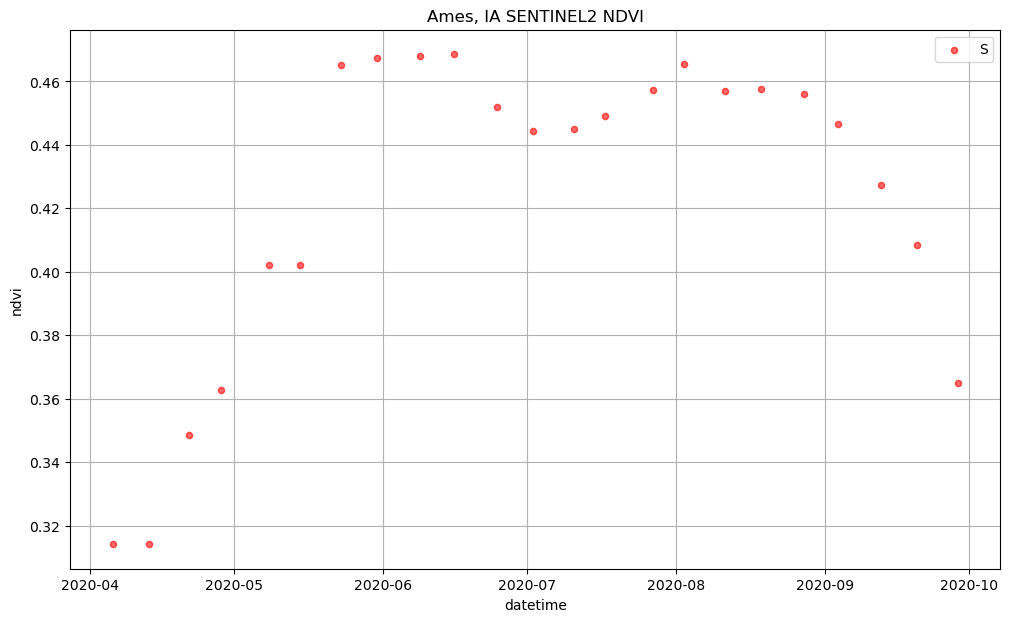

In [61]:
# Plot just the SENTINEL2 NDVI.
fig, ax = plt.subplots()

for i in s2_ndvi_df.color.unique():
    df_color = s2_ndvi_df[s2_ndvi_df.color==i]
    df_color.plot.scatter(x='datetime', y='ndvi', ax=ax, c=i, label=df_color.color.iloc[0],
                         grid=True, alpha=0.6, figsize=(12,7))


ax.set_title('Ames, IA SENTINEL2 NDVI')
plt.legend('S2-median composite NDVI')

#### Plot MODIS and SENTINEL2 NDVI

In [ ]:
fig, ax = plt.subplots()
for i in full_ndvi_df.color.unique():
    df_color = full_ndvi_df[full_ndvi_df.color==i]
    df_color.plot.scatter(x='datetime', y='ndvi', ax=ax, c=i, label=df_color.color.iloc[0],
                         grid=True, alpha=0.6, figsize=(12,7))


ax.set_title('Hanford STARFM Processing - NDVI');
plt.legend(['MCD43A4-S2-STARFM', 'S2-median composite']);

Next, we will check the MCD43A4 data which was used as an input to produce the fused surface reflectance data. Let's retrieve that data from the STAC API

In [15]:
search = catalog.search(
    collections = [f"prepped_inputs_mcd43a4{coll}"],
    bbox=bbox,
    #intersects=point,
    datetime = [start_date, end_date],
    max_items = 500
)

mcd_items = search.get_all_items()
print(f'number of source MODIS SR items: {len(mcd_items)}')

number of source MODIS SR items: 364


We'll sample the MCD43 items the same as before, but using the correct bands for MCD43A4. See this table for the band mappings (https://eos.com/find-satellite/modis-mcd43a4/). We will use bands 1 and 2, which are indexed by `0` and `1`.

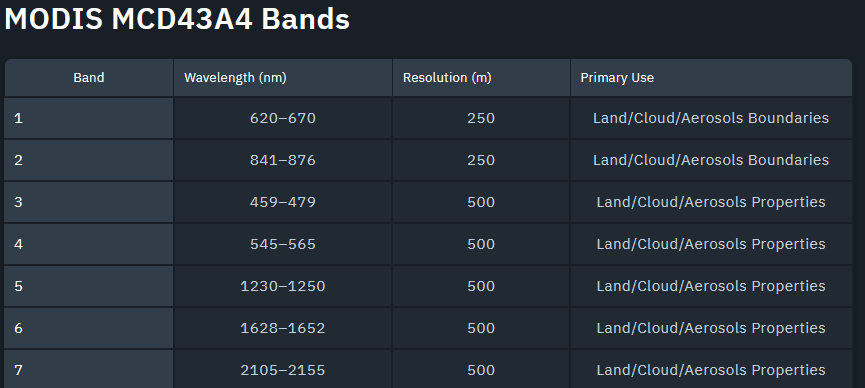

In [16]:
# sample the MCD43 items
mcd_res = FH_Hydrosat(mcd_items, asset='surface_reflectance')
mcd_red_ts = mcd_res.point_time_series_from_items(point_wgs84, tol=1000, nproc=6, band=0) 
mcd_nir_ts = mcd_res.point_time_series_from_items(point_wgs84, tol=1000, nproc=6, band=1) 
mcd_dt = mcd_res.datetime

using 6 processes to sample 364 assets
using 6 processes to sample 364 assets


As before, we will construct the NDVI series and pass it to a DataFrame, this time specifying `cyan` in the color column.

In [17]:
mcd_ndvi_ts = (np.array(mcd_nir_ts) - np.array(mcd_red_ts)) / (np.array(mcd_nir_ts) + np.array(mcd_nir_ts))

mcd_ndvi_df = pd.DataFrame({'ndvi': mcd_ndvi_ts,
                          'datetime': pd.to_datetime(mcd_dt)}).sort_values(by='datetime')
mcd_ndvi_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in mcd_ndvi_df['datetime']]

mcd_ndvi_df = mcd_ndvi_df.set_index(mcd_ndvi_df['date'])
mcd_ndvi_df['color'] = 'cyan'

`full_ndvi_df2` will hold the fused NDVI, Sentinel-2 NDVI, and MCD43A4 NDVI in a single DataFrame.

In [18]:
full_ndvi_df2 = pd.concat((ndvi_df, s2_ndvi_df, mcd_ndvi_df), axis=0)
full_ndvi_df2.sort_index(inplace=True)

Finally, we plot them all together.

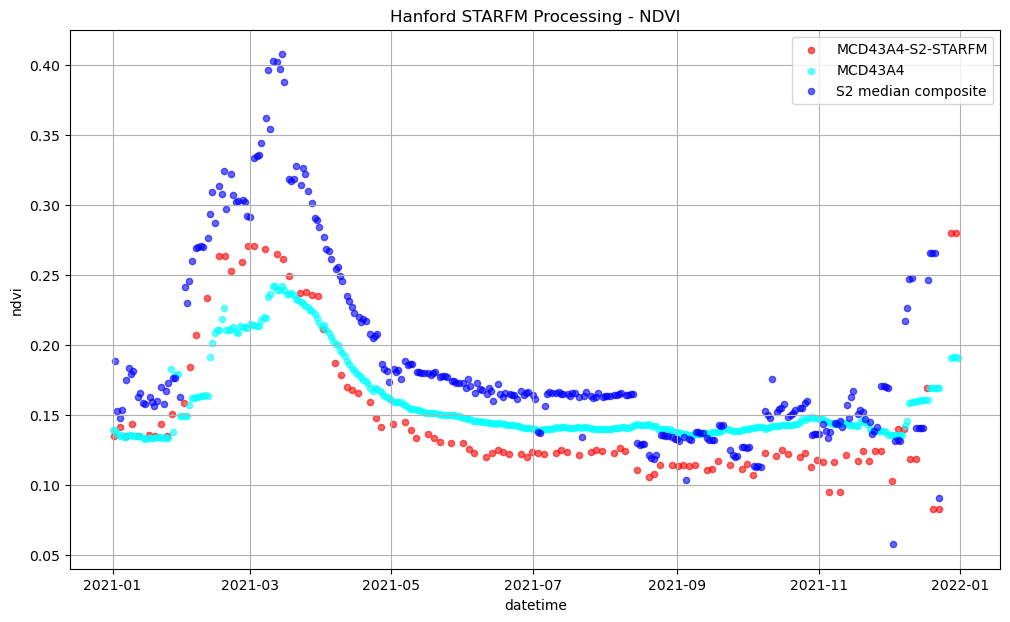

In [19]:
fig, ax = plt.subplots()
for i in full_ndvi_df2.color.unique():
    df_color = full_ndvi_df2[full_ndvi_df2.color==i]
    df_color.plot.scatter(x='datetime', y='ndvi', ax=ax, c=i, label=df_color.color.iloc[0],
                         grid=True, alpha=0.6, figsize=(12,7))


ax.set_title('Hanford STARFM Processing - NDVI');
plt.legend(['MCD43A4-S2-STARFM', 'MCD43A4', 'S2 median composite']);

There are some obvious differences in the NDVI plots above, namely that the NDVI calculated from the MODIS MCD43A4 product is often lower than the Sentinel-2 data. One difference is the MCD43A4 product is adjusted for different viewing angles through Bidirectional-Reflectance Distribution Function (BRDF), and is a "best-of" product constructed from daily observations over the course of 16 days. Addtionally, there are spectral bandwidth differences in the bands used to construct NDVI between Sentinel-2 and the MODIS MCD43A4 surface reflectance products (shown below). The MODIS product provides the daily surface reflectance information to the fusion process and the fused NDVI values will track those values.

(band information retrieved from https://landsat.usgs.gov/spectral-characteristics-viewer)

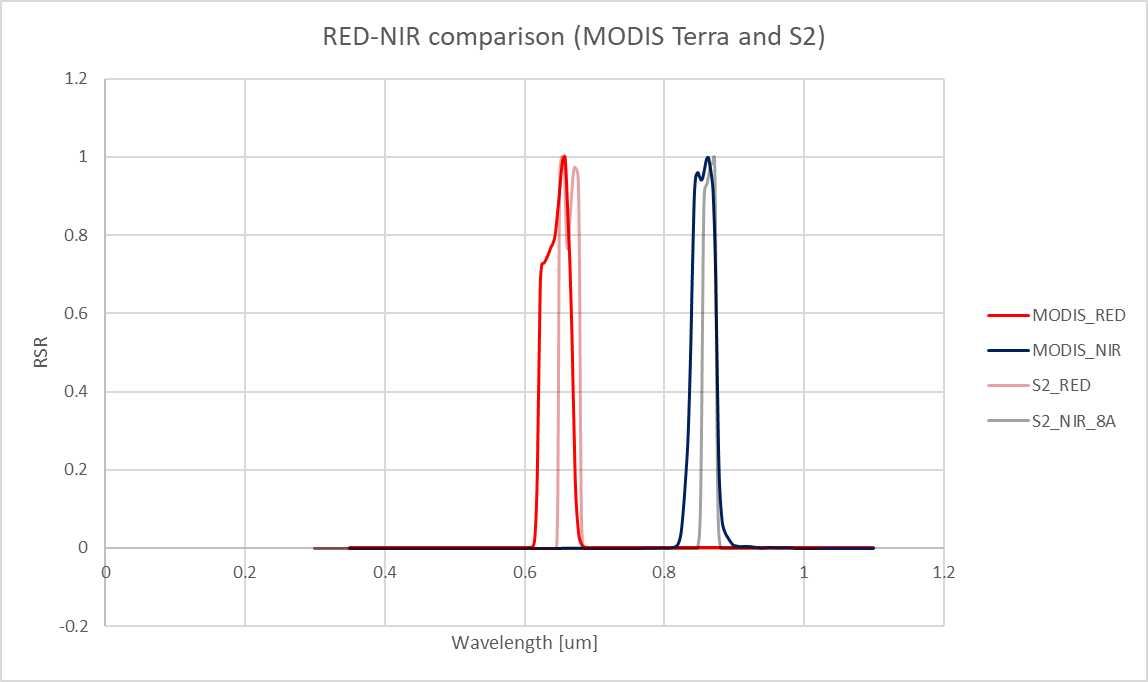